# Assignment 2

## Problem 1: Gillespie's Direct Algorithm

In [186]:
from IPython.display import Image
import scipy
from scipy import fftpack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pp
from scipy import integrate, optimize
from scipy.integrate import odeint
from random import random
import math
from scipy.interpolate import interp1d

## Defining the functions for the first problem

In [187]:
def Gillespie_direct_algorithm(beta, gamma, mu, psi, N, X, Y, Z, time):
    
    '''
        Defining the different rates

        recovery rate = gamma * Y
        infection rate = beta * X * Y / N
        birth rate = mu * N
        death rates = mu * (X,Y,Z)
        import rates = rho * sqrt(N) 
    '''
    

    '''
        Initialising the time and the vectors containign the numbers
        of infected/subsceptible and recovered individuals  
    '''
    t = 0
    inf = []
    sub = []
    rec = []
    T = []
    extintions = 0

    # cycle
    while t < time:

        # total rate is the sum of all the rates
        rates = [gamma * Y, beta * X * Y / N, mu * N, mu * Y, mu * Z, mu * X, psi * math.sqrt(N)]
        total_rate = sum(rates)

        # time-step 
        dt = - math.log(random()) / total_rate
        t += dt
        
        # what's the next event?
        P = random() * total_rate

        if P < rates[0]: # recovered
            Z += 1
            Y -= 1 
            X = X
        elif P < sum(rates[:2]): # infected
            Y += 1
            X -= 1
            Z = Z
        elif P < sum(rates[:3]): # birth
            Y = Y
            X += 1
            Z = Z
        elif P < sum(rates[:4]): # death of a infective
            Y -= 1
            X = X
            Z = Z
        elif P < sum(rates[:5]): # death of a recovered
            Y = Y
            X = X
            Z -= 1
        elif P < sum(rates[:6]): # death of subsceptible
            Y = Y
            X -= 1
            Z = Z
        elif P < sum(rates[:7]): # imports
            Z = Z
            X = X - 1
            Y = Y + 1


        inf.append(Y)
        if inf[-1] == 0 and inf[-2] !=0:
            extintions += 1
        rec.append(Z)
        sub.append(X)
        T.append(t)
        
    return inf, rec, sub, T, extintions


# Defining the SIR model
# Density-dependent transmission 

def sir_model_continous(y, x, beta, gamma, mu, psi):
    S = mu*(y[0]+y[1]+y[2]) - beta * y[0]* y[1]/(y[0]+y[1]+y[2]) - mu * y[0] - psi * (y[0]+y[1]+y[2])**0.5
    I = beta * y[0] * y[1]/(y[0]+y[1]+y[2]) - (gamma + mu)*y[1] + psi * (y[0]+y[1]+y[2])**0.5
    R = gamma * y[1] - mu * y[2]
    return S, I, R


In [278]:
def Plotter(n_simulation,beta,gamma,mu,psi,X,Y,Z,t,scale=False):
    N = X + Y + Z
    y_sim_i = []
    y_sim_s = []
    y_sim_r = []
    t_range = np.linspace(0,t, 2000)
    for i in range(0,n_simulation):
        inf, rec, sub, T, extintions = Gillespie_direct_algorithm(beta, gamma, mu, psi, N, X, Y, Z, t)
        
        #interpolation for the infecteds
        f = interp1d(T, inf,fill_value="extrapolate") #interpolation
        y_values_i = f(t_range)
        y_sim_i.append(y_values_i)
        
        #interpolation for the subsceptibles
        g = interp1d(T, sub,fill_value="extrapolate") #interpolation
        y_values_s = g(t_range)
        y_sim_s.append(y_values_s)
        
        #interpolation for the recovered
        h = interp1d(T, rec,fill_value="extrapolate") #interpolation
        y_values_r = h(t_range)
        y_sim_r.append(y_values_r)
        
    means_i = []
    stds_i = []
    means_r = []
    stds_r = []
    means_s = []
    stds_s = []
    
    for i in range(0,len(y_sim_i[0])):
        
        column_i = [row[i] for row in y_sim_i]
        means_i.append(np.mean(column_i, axis = 0))
        stds_i.append(np.std(column_i, axis = 0))
        
        column_s = [row[i] for row in y_sim_s]
        means_s.append(np.mean(column_s, axis = 0))
        stds_s.append(np.std(column_s, axis = 0))
        
        column_r = [row[i] for row in y_sim_r]
        means_r.append(np.mean(column_r, axis = 0))
        stds_r.append(np.std(column_r, axis = 0))
    
    
    
    sol = odeint(sir_model_continous,[X,Y,Z], t_range, (beta, gamma, mu,psi))
    S = sol[:, 0]
    I = sol[:, 1]
    R = sol[:, 2]
    
    #plots
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(t_range, means_s, alpha = 0.9)
    plt.fill_between(t_range,np.subtract(means_s,stds_s),np.add(means_s,stds_s),alpha=0.2)
    plt.plot(t_range, S, color = "black",linestyle = "dashed", alpha = 0.5)
    plt.plot(t_range, means_r, alpha = 0.9)
    plt.fill_between(t_range,np.subtract(means_r,stds_r),np.add(means_r,stds_r),alpha=0.2)
    plt.plot(t_range, R, color = "black",linestyle = "dashed", alpha = 0.5)
    plt.plot(t_range, means_i, alpha = 0.9)
    plt.fill_between(t_range,np.subtract(means_i,stds_i),np.add(means_i,stds_i),alpha=0.2)
    plt.plot(t_range, I, color = "black",linestyle = "dashed", alpha = 0.5)
    plt.grid()
    plt.legend()
    plt.xlabel("t (years)")
    plt.show()
    
    
    print("number of extintions: ",extintions)
    
    
    


## increased transient

No handles with labels found to put in legend.


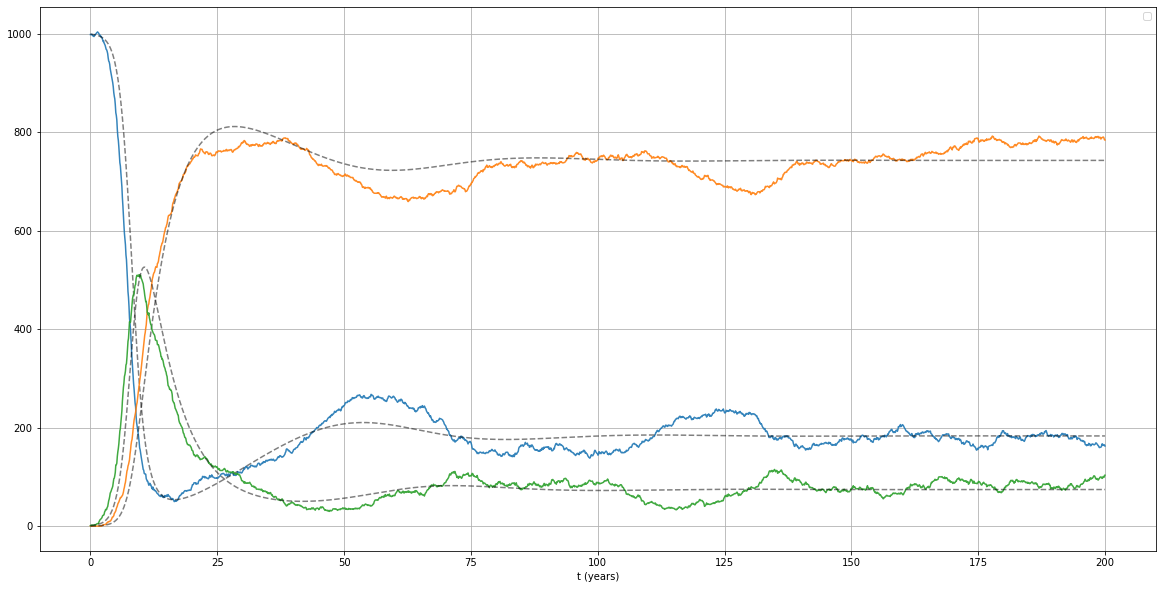

number of extintions:  0


No handles with labels found to put in legend.


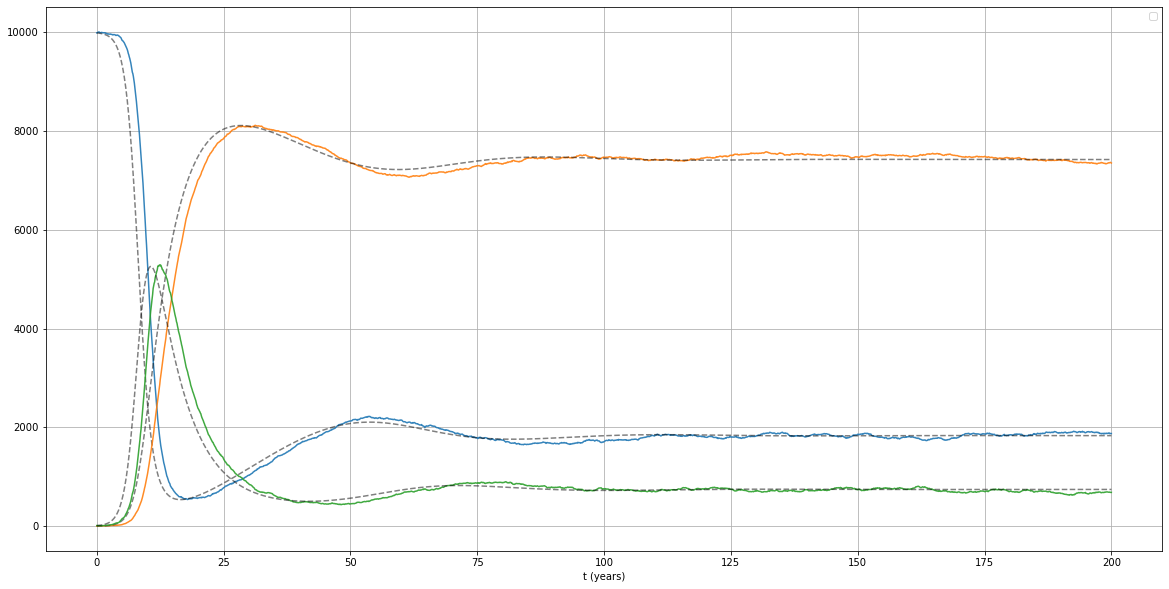

number of extintions:  0


In [323]:
# Defining the parameters 
# Parameter values and initial conditions:
beta = 1
gamma = 1/6
mu = 1/60
psi = 5.5e-4
nu = 1/60
rho = 0
N = 1000
X = 999
Y = 1
Z = 0


Plotter(1,1,1/6,1/60,5.5e-4,999,1,0,200)

Plotter(1,1,1/6,1/60,5.5e-4,9990,10,0,200)





## Extinction

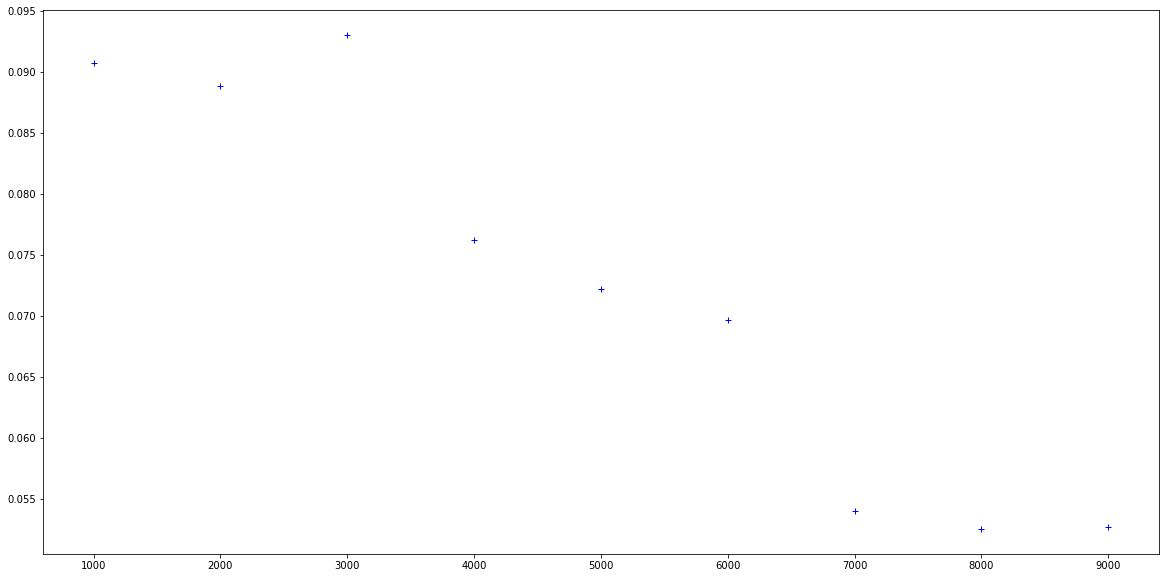

In [322]:
def PlotterExctintion(n_simulation,beta,gamma,mu,psi,N,t):
    for j in np.arange(N,N*10,N):
        X = j*0.9
        Y = j*0.1
        Z = 0
        extintions_mean = 0
        
        for i in range(0,n_simulation):
            inf, rec, sub, T, extintions = Gillespie_direct_algorithm(beta, gamma, mu, psi, j, X, Y, Z, t)
            extintions_mean += extintions
            
        extintions_mean = extintions_mean/(n_simulation*t)
        #plots
        plt.plot(j,extintions_mean,"b+")
    plt.show()

PlotterExctintion(20,1,0.8,1/70,6e-3,1000,300)


No handles with labels found to put in legend.


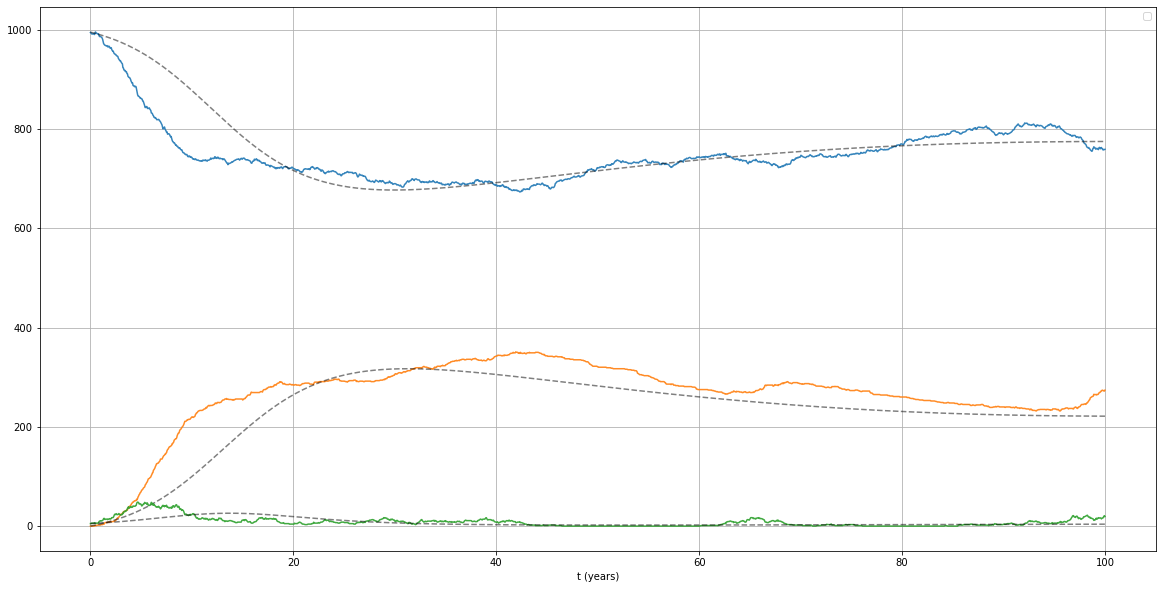

number of extintions:  5


In [326]:
Plotter(1,1,0.8,1/70,6e-3,995,5,0,100)

## Variability

No handles with labels found to put in legend.


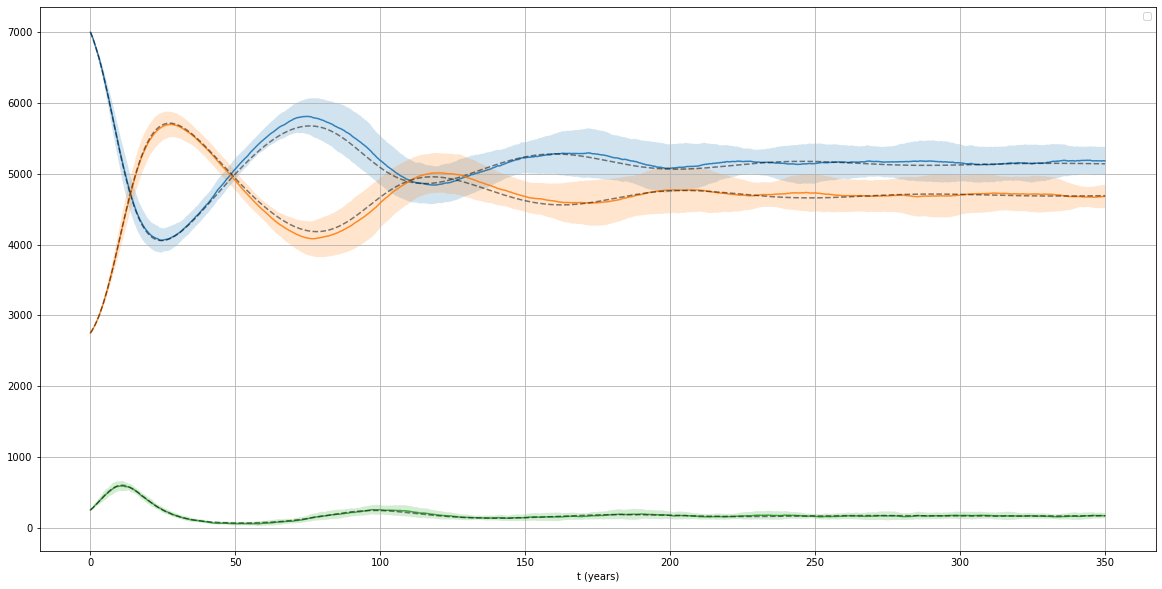

number of extintions:  0


No handles with labels found to put in legend.


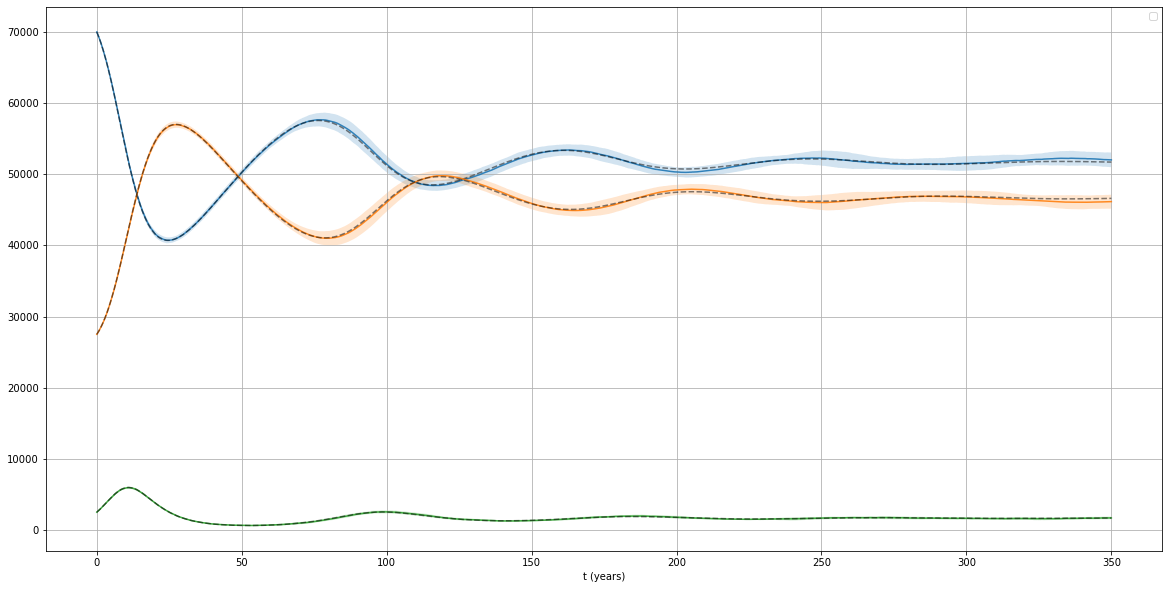

number of extintions:  0


In [286]:
Plotter(20,0.8,0.4,1/70,5.5e-3,7000,250,2750,350)
Plotter(20,0.8,0.4,1/70,5.5e-3,70000,2500,27500,350)

## covariance

In [100]:
def covariance(n_simulation,beta,gamma,mu,psi,X,Y,Z,t,scale=False):
    N = X + Y + Z
    t_range = np.linspace(t-650,t-10, 2000)
    inf, rec, sub, T = Gillespie_direct_algorithm(beta, gamma, mu, psi, N, X, Y, Z, t)
    g = interp1d(T,sub,fill_value="extrapolate") #interpolation for the subsceptibles
    f = interp1d(T, inf,fill_value="extrapolate") #interpolation for the infectives
    y_values_i = f(t_range)
    y_values_s = g(t_range)
    return np.cov(y_values_i,y_values_s)[1][0]
    

In [101]:
def func(x,a,b):
    return a + b * x

def plotterCovariance(N,n):
    ydata = []
    for i in np.linspace(N/100,N,n):
        X = 0.99*i
        Y = 0.01*i
        cov = []
        for j in range(0,10):
            cov.append(covariance(40,1,1/6,1/60,5.5e-4,X,Y,0,1000))
        plt.plot(i,np.mean(cov),"r+")
        ydata.append(np.mean(cov))
    popt, pcov = optimize.curve_fit(func, np.linspace(N/100,N,n), ydata)
    plt.plot(np.linspace(N/100,N,n),func(np.linspace(N/100,N,n),*popt))
    plt.show()

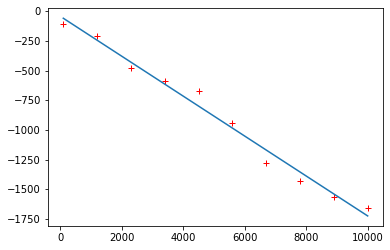

In [13]:
plotterCovariance(10000,10)

In [222]:
def Gillespie_direct_algorithm_resonance(beta0, gamma, mu, psi, N, X, Y, Z, time, beta1, w):
    
    t = 0
    inf = []
    sub = []
    rec = []
    T = []
    extintions = 0
    # cycle
    while t < time:

        # total rate is the sum of all the rates
        rates = [gamma * Y, beta0*(1-beta1*np.cos(w*t)) * X * Y / N, mu * N, mu * Y, mu * Z, mu * X, psi * math.sqrt(N)]
        total_rate = sum(rates)

        # time-step 
        dt = - math.log(random()) / total_rate
        t += dt
        
        # what's the next event?
        P = random() * total_rate

        if P < rates[0]: # recovered
            Z += 1
            Y -= 1 
            X = X
        elif P < sum(rates[:2]): # infected
            Y += 1
            X -= 1
            Z = Z
        elif P < sum(rates[:3]): # birth
            Y = Y
            X += 1
            Z = Z
        elif P < sum(rates[:4]): # death of a infective
            Y -= 1
            X = X
            Z = Z
        elif P < sum(rates[:5]): # death of a recovered
            Y = Y
            X = X
            Z -= 1
        elif P < sum(rates[:6]): # death of subsceptible
            Y = Y
            X -= 1
            Z = Z
        elif P < sum(rates[:7]): # imports
            Z = Z
            X = X - 1
            Y = Y + 1


        inf.append(Y)
        if inf[-1] == 0 and inf[-2] !=0:
            extintions += 1
        rec.append(Z)
        sub.append(X)
        T.append(t)
        
    return inf, rec, sub, T, extintions


# Defining the SIR model
# Density-dependent transmission 

def sir_model_continous_resonance(y, x, beta0, gamma, mu, psi, beta1,w):
    S = mu*(y[0]+y[1]+y[2]) - (beta0*(1-beta1*np.cos(w*x))) * y[0]* y[1]/(y[0]+y[1]+y[2]) - mu * y[0] - psi * (y[0]+y[1]+y[2])**0.5
    I = (beta0*(1-beta1*np.cos(w*x))) * y[0] * y[1]/(y[0]+y[1]+y[2]) - (gamma + mu)*y[1] + psi * (y[0]+y[1]+y[2])**0.5
    R = gamma * y[1] - mu * y[2]
    return S, I, R


In [270]:
inf, rec, sub, T, extintions = Gillespie_direct_algorithm_resonance(1, 1/10, 1/50, 5e-5, 1000, 900, 100, 0, 350, 1/3, np.pi/26)
sol = odeint(sir_model_continous_resonance,[900, 100, 0], np.linspace(0,350,200000), (1, 1/10, 1/50, 5e-5, 1/3, np.pi/26))
S = sol[:, 0]
I = sol[:, 1]
R = sol[:, 2]




No handles with labels found to put in legend.
No handles with labels found to put in legend.


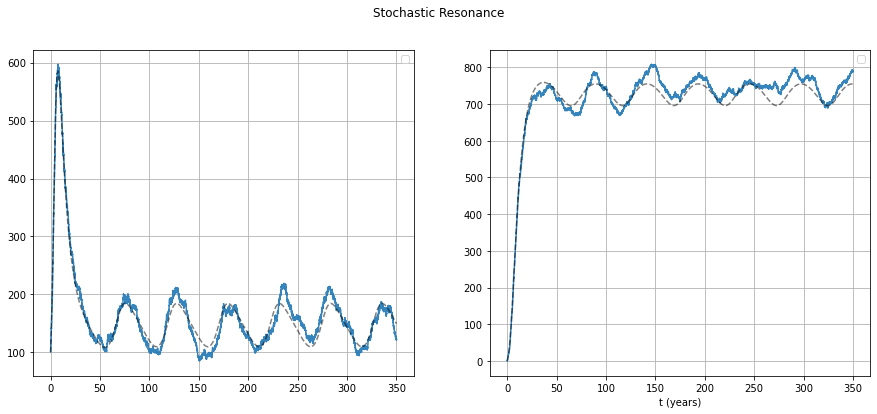

No handles with labels found to put in legend.


200000


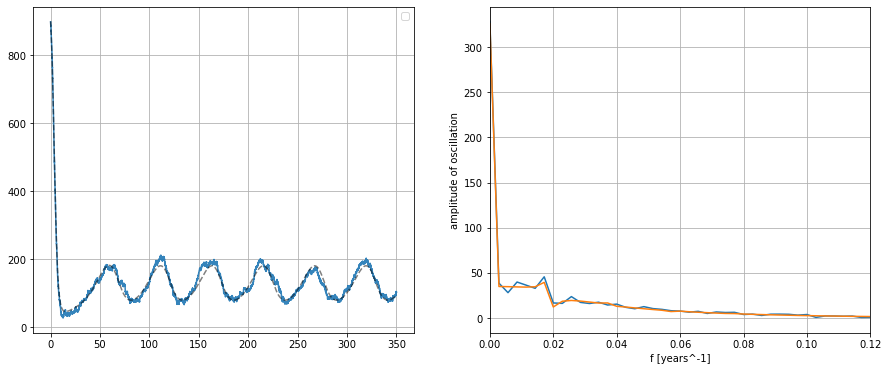

In [271]:
#plots
fig, (ax1,ax2) = plt.subplots(1,2,figsize =(15,6))
fig.suptitle("Stochastic Resonance")
ax1.plot(T, inf, alpha = 0.9)
ax1.plot(np.linspace(0,350,200000), I, color = "black",linestyle = "dashed", alpha = 0.5)
ax1.grid()
ax1.legend()
ax2.plot(T, rec, alpha = 0.9)
ax2.plot(np.linspace(0,350,200000), R, color = "black",linestyle = "dashed", alpha = 0.5)
ax2.grid()
ax2.legend()
plt.xlabel("t (years)")
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2,figsize =(15,6))
ax1.plot(T, sub, alpha = 0.9)
ax1.plot(np.linspace(0,350,200000), S, color = "black",linestyle = "dashed", alpha = 0.5)
ax1.grid()
ax1.legend()

x = np.linspace(0,350,200000)
f = interp1d(T, inf,fill_value="extrapolate") #interpolation
y = f(x)
print(len(y))
yf = fftpack.fft(y) #Fast Fourier Transform of y 
xf = fftpack.fftfreq(200000, 350/200000)[:round(200000/2)]#fftfreq returns the FFT sample frequency points.
y1 = I
yf1 = fftpack.fft(y1) #Fast Fourier Transform of y 
xf1 = fftpack.fftfreq(200000, 350/200000)[:round(200000/2)]#fftfreq returns the FFT sample frequency points.


ax2.plot(xf, 2.0/200000 * np.abs(yf[0:round(200000//2)]))
ax2.plot(xf1, 2.0/200000 * np.abs(yf1[0:round(200000//2)]))

plt.xlim(0,0.12)
plt.xlabel("f [years^-1]")
plt.ylabel("amplitude of oscillation")
plt.grid()
plt.show()









